In [10]:
import numpy as np

from backtester.options import Option, OptionChain, Loader
from backtester.utils import find_option_by_desc, find_option_exact

In [271]:
%aimport -OptionChain

In [13]:
from os import listdir
from os.path import isfile, join

data_paths = [f"./data/{f}" for f in listdir('./data') if isfile(join('./data', f))]

In [14]:
# load data
loader = Loader()
loader.load_data(data_paths, True)

In [17]:
import pandas as pd

dates = pd.DataFrame(list(loader.data['AMZN'].keys())[3:-3], dtype='datetime64[D]')
dates_array = dates.values.astype('datetime64[D]').flatten()

In [617]:
from backtester.strategy import Leg, Strategy

In [1031]:
leg_1 = Leg(dates_array, loader, np.datetime64('2020-11-27'))
leg_1.ticker = "COST"
leg_1.side = 's'
leg_1.quantity = 3
leg_1.opt_type = 'put'
leg_1.tenor_day = 7
leg_1.moneyness = 1.0
leg_1.open_frequency_d = 'roll'
leg_1.close_n_tday_before = 0
leg_1.open_px = 'mid'
leg_1.close_px = 'mid'
leg_1.decider = decider

In [1032]:
leg_2 = Leg(dates_array, loader, np.datetime64('2020-11-27'))
leg_2.ticker = "COST"
leg_2.side = 'l'
leg_2.quantity = 3
leg_2.opt_type = 'put'
leg_2.tenor_day = 30
leg_2.moneyness = 0.8
leg_2.open_frequency_d = "roll"
leg_2.close_n_tday_before = 0
leg_2.open_px = 'mid'
leg_2.close_px = 'mid'

In [1033]:
strat = Strategy([leg_1, leg_2])
df = strat.get_stats()

In [1034]:
df['cummulative_real_pnl'][-1]

29176.5

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

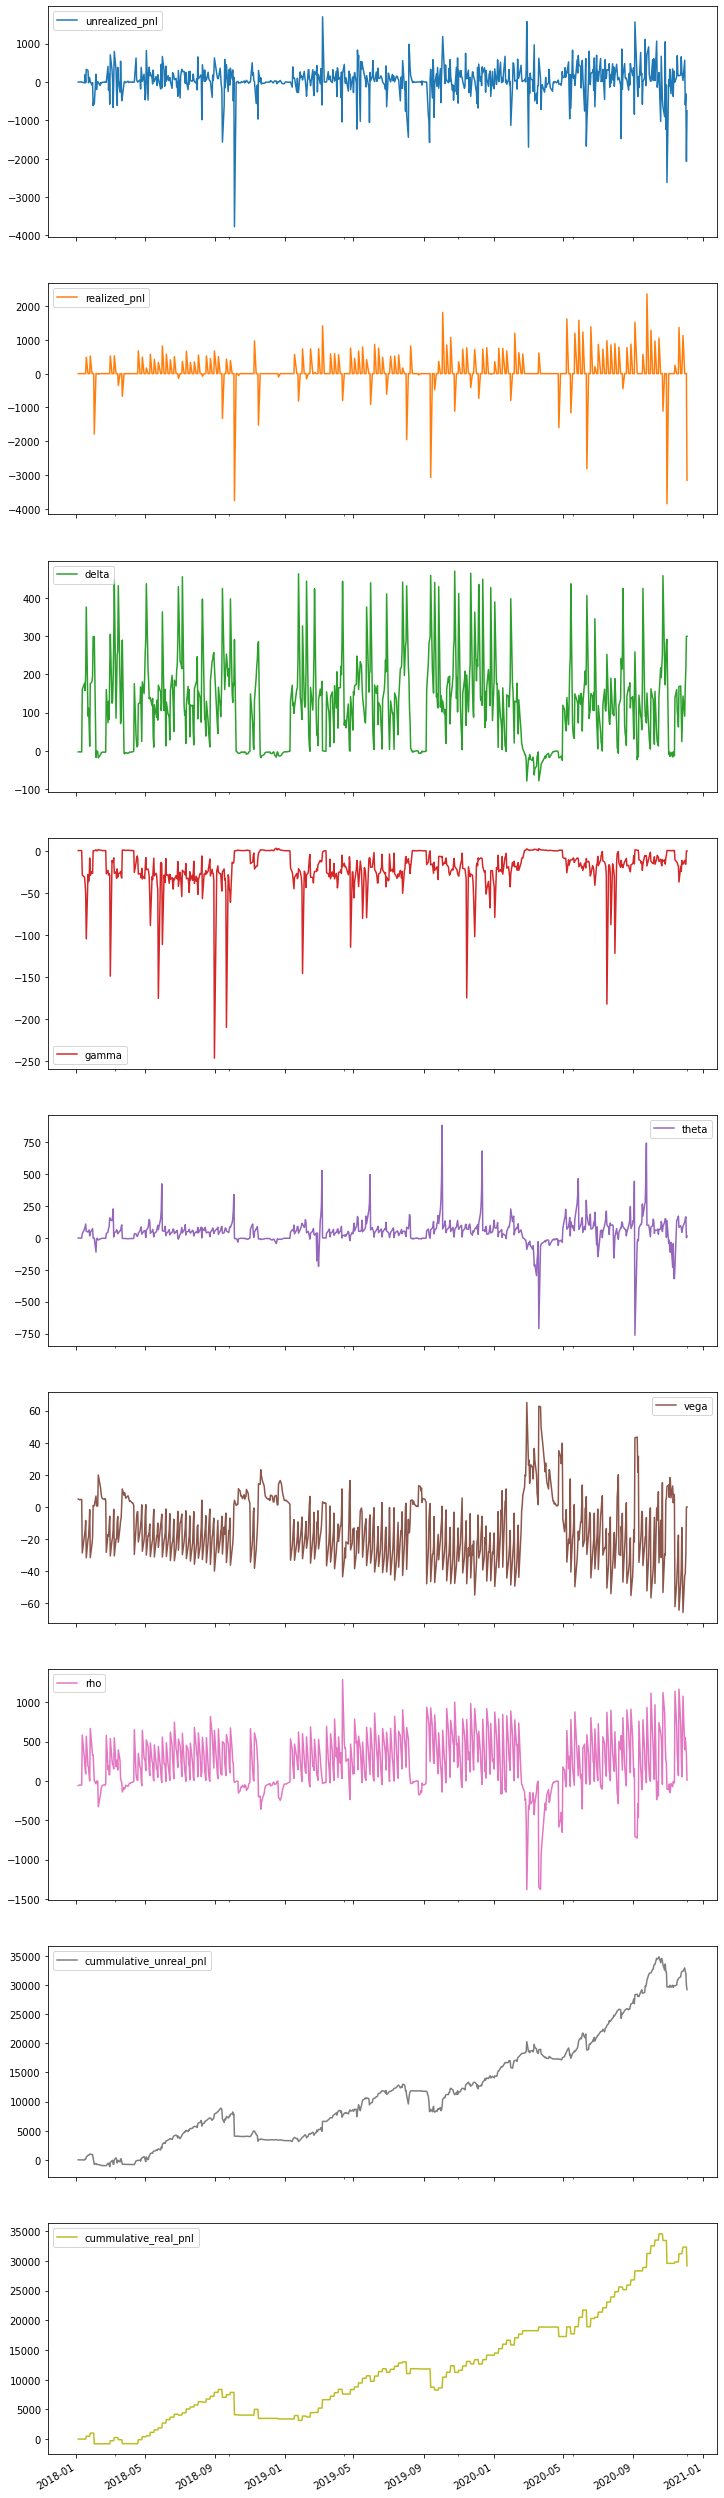

In [1035]:
df.plot(subplots=True, figsize=(12, 50))

In [730]:
import yfinance as yf

In [1016]:
train = yf.Ticker("COST").history(start="2001-01-01", end="2017-12-31")['Close'].to_frame().pct_change().dropna()
test = yf.Ticker("COST").history(start="2018-01-01", end="2020-12-31")['Close'].to_frame().pct_change().dropna()

In [1017]:
from hmmlearn import hmm

model = hmm.GaussianHMM(n_components=2, n_iter=1000000, covariance_type="diag")
model.fit(train)
train_res = model.predict(train)
test_res = model.predict_proba(test)

In [1018]:
test_res = test_res[:,0]

In [1022]:
res = np.where(np.expand_dims(test_res, 0) < 0.9, 1, 0)

In [1023]:
regime = yf.Ticker("COST").history(start="2018-01-01", end="2020-12-31")['Close'][1:].to_frame()
regime['regime'] = res.flatten()

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

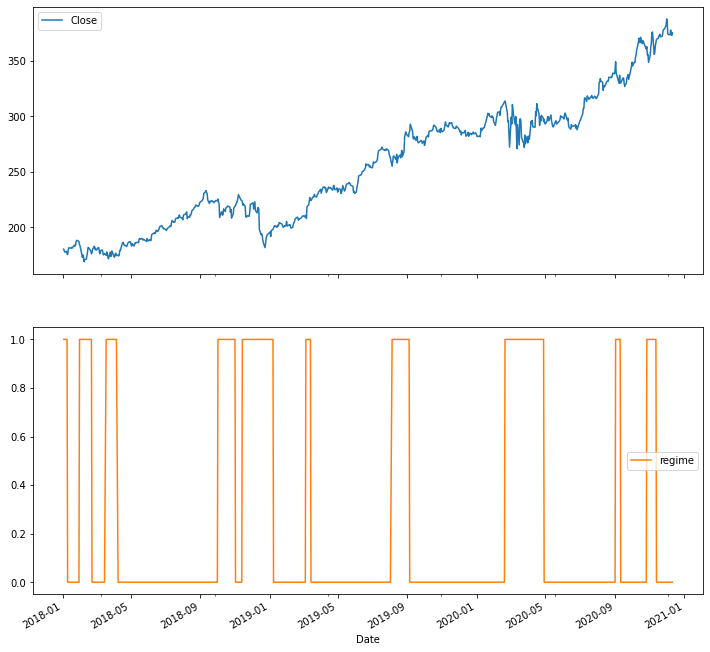

In [1024]:
regime.plot(subplots=True, figsize=(12,12))

In [965]:
def decider(date):
    if regime.loc[date]['regime'] == 1.0:
        return False
    else:
        return True

In [977]:
import pickle
pickle.dump(model, open( "./models/goog_hmm.pkl", "wb" ) )